## Test of DetSim

In [2]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy     as np
import pandas    as pd
from   scipy     import stats
import os
import matplotlib.pyplot as plt

import xyimg.dataprep as dp
import xyimg.detsim   as dsim
#import xyimg.cnn      as cnn

In [194]:
pressure = '5bar'
sample   = '1eroi'

path      = os.environ['LPRDATADIR']
ifilename = path + dp.voxel_filename(pressure, sample)
ofile     = 'temp.h5'


In [246]:
nevents  = 1
width    = (2., 2., 2.)
sigma    = (0., 0., 0.)
wi       = 25. # eV

voxels = pd.read_hdf(ifilename, 'voxels')

df     = dsim.run(ifilename, ofile, width, sigma, wi, nevents = nevents)

input  filename  /scratch/next/data/NEXT100/pressure_topology/voxel_dataset_5bar_1eroi.h5
output filename  temp.h5
widths     (mm)  (2.0, 2.0, 2.0)
sigmas     (mm)  (0.0, 0.0, 0.0)
wi         (eV)  25.0
events           1


In [247]:
df

,file_id,event,binclass,x,y,z,E,track_id,nhits,ext,segclass
0,1,0,0,284.084192,208.240157,40.005596,0.000125,0,7,0,3
1,1,0,0,284.042402,208.500294,41.231435,0.041503,0,0,0,0
2,1,0,0,284.033650,208.524089,42.499640,0.016525,0,0,0,0
3,1,0,0,284.456562,210.578753,37.504006,0.000476,0,7,0,3
4,1,0,0,284.315539,210.117587,39.092949,0.000375,0,7,0,3
...,...,...,...,...,...,...,...,...,...,...,...
688,1,0,0,425.858084,247.526449,67.496294,0.001972,0,0,0,0
689,1,0,0,425.893778,247.485204,68.421435,0.001897,0,0,0,0
690,1,0,0,427.033103,245.003417,68.446577,0.000025,0,0,0,0
691,1,0,0,427.534080,245.909804,67.482192,0.000848,0,0,0,0


In [257]:
ievt = 0
white = 2
#----
def plot_xy(df, ievt, proyection, width = 2):
    l0, l1 = proyection
    sel    =  np.logical_and(df.file_id == 1, df.event == ievt)
    xdf    = df[sel]
    bins   = [np.arange(np.min(x) - width, np.max(x) + width, width) for x in (xdf[l0].values, xdf[l1].values)]
    plt.hist2d(xdf[l0].values, xdf[l1].values, weights = df['E'].values, bins = bins);
    tsel = (xdf.ext > 0 )
    plt.scatter(xdf[l0][tsel].values, xdf[l1][tsel].values, marker = 'D', color = 'white');
    return

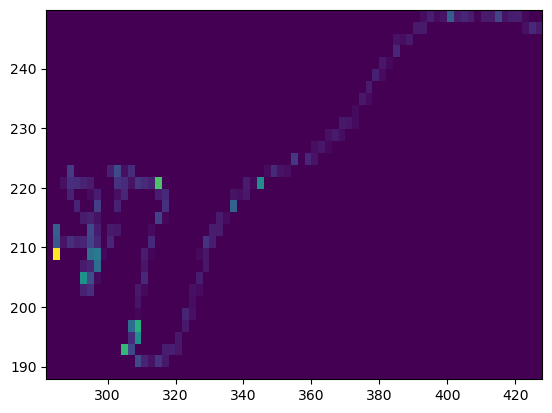

In [259]:
ievt = 0
plot_xy(df, ievt, ('x', 'y'))

In [264]:
sel = (voxels.file_id == 1) & (voxels.event == ievt)
evt = voxels[sel]
evt

,file_id,event,x,y,z,E,binclass,segclass,track_id,nhits,ext
0,1,0,283,208,40,0.040549,0,2,0,14,0
1,1,0,283,208,41,0.069277,0,2,0,21,1
2,1,0,283,209,41,0.012017,0,2,0,1,0
3,1,0,284,208,40,0.013737,0,2,0,2,0
4,1,0,284,210,37,0.002855,0,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
485,1,0,423,246,67,0.009428,0,1,0,1,0
486,1,0,423,247,67,0.003023,0,1,0,1,0
487,1,0,424,246,67,0.004564,0,1,0,2,0
488,1,0,425,246,67,0.006591,0,1,0,3,0


In [313]:
width    = (2., 2., 2.)
sigma    = (0., 0., 0.)
wi       = 25. # eV
dd       = dsim.event_smear(evt, width, sigma, wi)
dd       = pd.DataFrame(dd)

In [266]:
np.sum(dd.E)

2.457999999227468

In [267]:
len(evt), len(dd)

(490, 19570)

In [268]:
pos      = [evt[label].values for label in ('x', 'y', 'z')]
ene      =  evt['E'].values
segclass = dsim._segclass(evt['segclass'].values)
ext      = evt['ext'].values

ie_pos, ie_ene        = dsim.ielectrons(pos, ene, width, sigma, wi)
xpos, xene, bins, sel = dsim.voxelize(ie_pos, ie_ene, width)
xsegclass             = dsim.val_in_frame(pos, segclass, bins, sel).astype(int)
xext                  = dsim.val_in_frame(pos, ext, bins, sel).astype(int)


In [272]:
def get_event(df, file_id, event):
    return df[(df.file_id == file_id) & (df.event == event)]

In [343]:
ievt = 1
width0 = (0., 0., 0.)
sigma  = (0., 0., 0.)
width1 = (2., 2., 2.)
vevt = get_event(voxels, 1, ievt)
devt = dsim.event_smear(vevt, width, sigma, width1, wi)
devt = pd.DataFrame(devt)

In [344]:
pos  = [vevt[label].values for label in ('x', 'y', 'z')]
ene  =  vevt['E'].values
ext  =  vevt['ext'].values

xpos = [devt[label].values for label in ('x', 'y', 'z')]
xene = devt['E'].values
xext = devt['ext'].values

bins = [np.arange(np.min(x) - 2.*w, np.max(x) + 2.*w, w) for x, w in zip(xpos, width)]


In [345]:
np.sum(xext), np.sum(ext)

(3, 3)

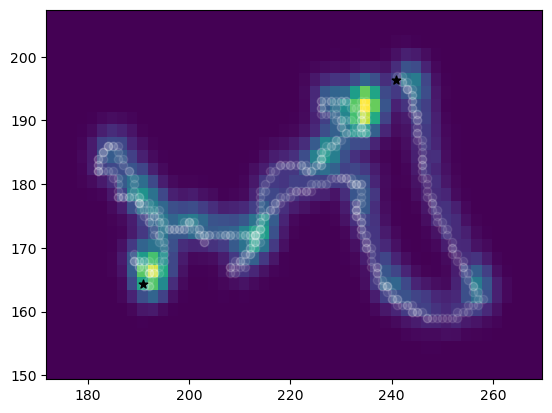

In [346]:
i0, i1 = 0, 1
plt.hist2d(xpos[i0], xpos[i1], weights = xene, bins = (bins[i0], bins[i1]));
plt.scatter(pos[i0], pos[i1], alpha = 0.1, color = 'white')
plt.scatter(xpos[i0][xext > 0], xpos[i1][xext > 0], alpha = 1., color = 'black', marker='*', s = 40)


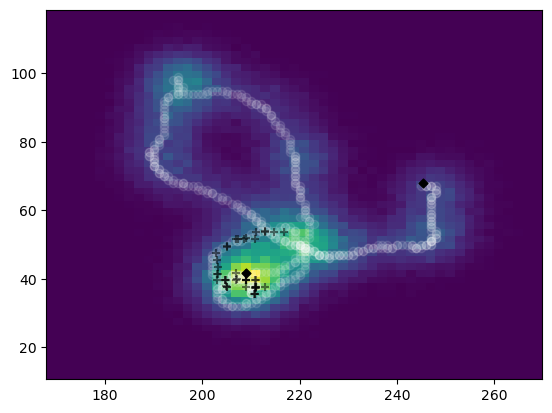

In [269]:
i0, i1 = 1, 2
plt.hist2d(xpos[i0], xpos[i1], weights = xene, bins = (bins[i0], bins[i1]));
plt.scatter(pos[i0], pos[i1], alpha = 0.1, color = 'white')
plt.scatter(xpos[i0][xsegclass == 3], xpos[i1][xsegclass == 3], alpha = .5, color = 'black', marker='+')
plt.scatter(xpos[i0][xext > 0], xpos[i1][xext > 0], alpha = 1., color = 'black', marker='D', s = 20)



In [48]:
np.sum(ene), np.sum(ie_ene)

(2.457999998430296, 2.457999998430296)

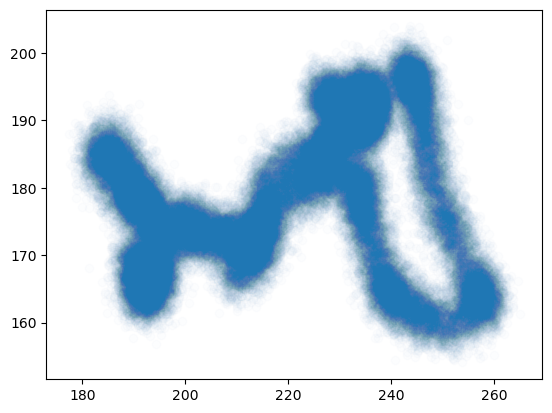

In [54]:
plt.scatter(ie_pos[0], ie_pos[1], alpha = 0.01)

In [1]:
ievt = evt[['x', 'y', 'z', 'E']]

NameError: name 'evt' is not defined

In [62]:
ievt

,x,y,z,E
490,182,182,436,0.003871
491,182,182,437,0.001494
492,182,182,438,0.001365
493,182,183,438,0.002234
494,182,183,439,0.005366
...,...,...,...,...
919,256,164,392,0.003523
920,257,161,390,0.006627
921,257,162,391,0.003436
922,257,163,391,0.004179


In [63]:
np.sum(ievt.E)

2.457999998430296

In [40]:
smear = dsim.get_smear(0., 0., 0.)

In [41]:
svoxels = [smear(voxel.x, voxel.y, voxel.z, voxel.E) for i, voxel in ievt.iterrows()]

In [44]:
ie_pos = [np.concatenate([s[i] for s in svoxels]) for i in range(2)]
ie_ene = np.concatenate([s[3] for s in svoxels])

In [58]:
width = 2.
bins  = [np.arange(np.min(x) - 2.*width, np.max(x) + 2.*width, width) for x in ie_pos]

In [59]:
img , _, _ = stats.binned_statistic_dd(ie_pos, ie_ene,  bins = bins, statistic = 'count')

In [60]:
np.sum(img) * 25.*1e-6

2.4006499999999997

In [61]:
np.sum(ie_ene)

2458265.6

In [39]:
len(xs)

96026

In [33]:
x, y, z, E = [evt[label].values for label in ('x', 'y', 'z', 'E')]

In [62]:
ivoxel = 0
wi     = 25.
x0, y0, z0, E0 = x[ivoxel], y[ivoxel], z[ivoxel], E[ivoxel]
nsize = int(np.round(1e6*E0/wi))
print(x0, y0, z0, E0, nsize)

182 182 436 0.003871280001476407 155


In [73]:
smear                = dsim.get_smear(25., 2., 2., 2.)
positions, energies  = smear((x[ivoxel], y[ivoxel], z[ivoxel]), E[ivoxel])

In [74]:
white = 20 # mm
voxel_width = 2. #3 mm
frames = [(np.min(x) - white , np.max(x) + white) for x in (x, y, z)] 
bins   = [np.arange(*iframe, voxel_width) for iframe in frames]


In [75]:
index = (0, 1)
coors = [positions[i] for i in index]
cbins = [bins[i]    for i in index]
var   = energies
img , _, _ = stats.binned_statistic_dd(coors, var,  bins = cbins, statistic = 'count')

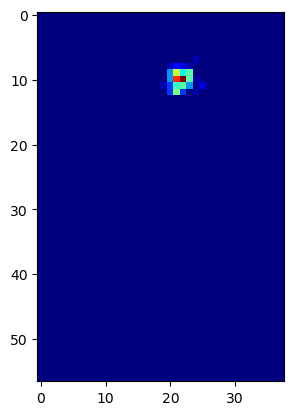

In [76]:
plt.imshow(img, cmap = 'jet')

In [ ]:
result = evt[['x', 'y', 'z', 'E']]

: 